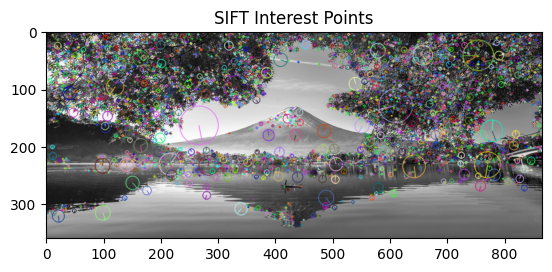

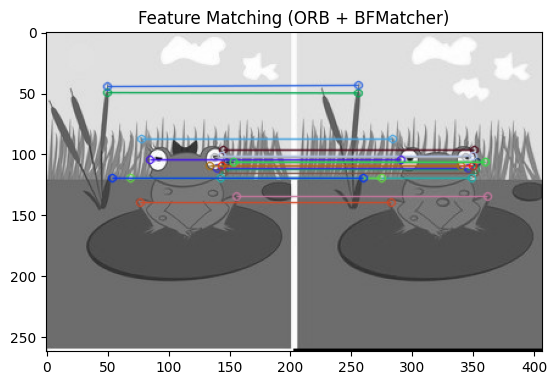

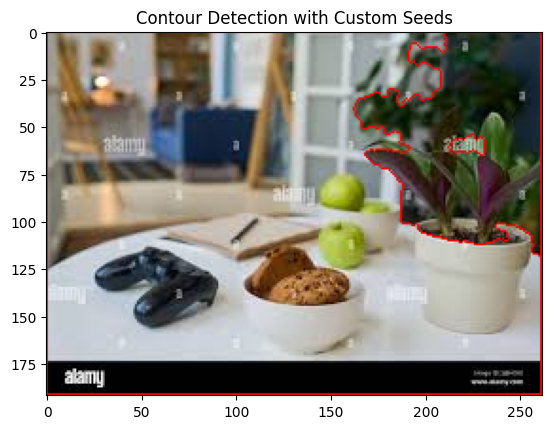

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def interest_point_detection(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)

    image_sift = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    plt.imshow(image_sift, cmap='gray')
    plt.title("SIFT Interest Points")
    plt.show()
    # return keypoints, descriptors

def feature_matching(image1_path, image2_path):
    img1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)

    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)

    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:20], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    plt.imshow(img_matches)
    plt.title("Feature Matching (ORB + BFMatcher)")
    plt.show()

def contour_detection(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    markers = cv2.connectedComponents(sure_fg)[1]
    markers += 1
    markers[unknown == 255] = 0

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.watershed(img, markers)
    img[markers == -1] = [255, 0, 0]

    plt.imshow(img)
    plt.title("Contour Detection with Custom Seeds")
    plt.show()

# Example Usage
interest_point_detection('nature.jpg')
feature_matching('img1.jpg', 'img2.jpg')
contour_detection('images.jpg')


In [ ]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available: 1


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.1188 - val_loss: 0.1140
Epoch 2/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.1121 - val_loss: 0.1140
Epoch 3/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1121 - val_loss: 0.1140
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


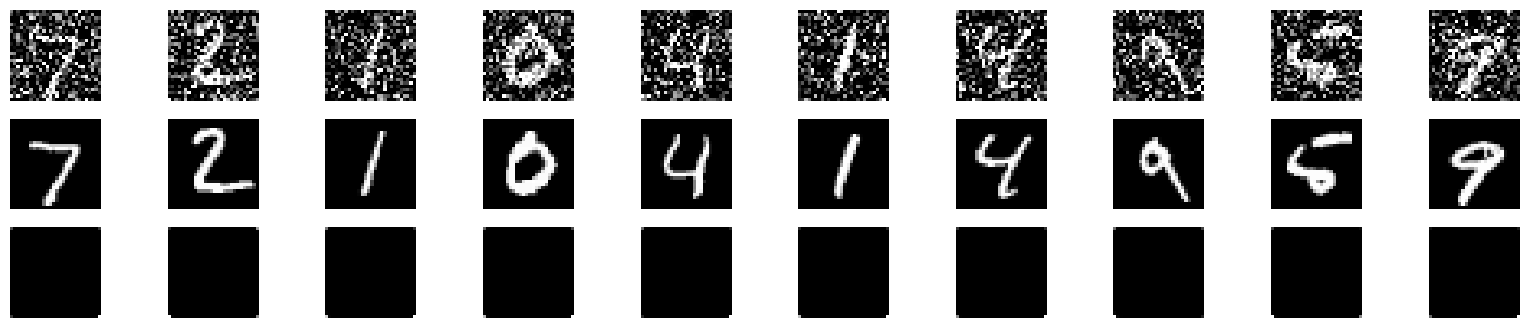

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

def load_and_preprocess_data():
    (x_train, _), (x_test, _) = mnist.load_data()
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    x_train = np.expand_dims(x_train, axis=-1)
    x_test = np.expand_dims(x_test, axis=-1)
    return x_train, x_test

def add_noise(images):
    noise_factor = 0.5
    noisy_images = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    return np.clip(noisy_images, 0., 1.)

def build_autoencoder():
    input_img = Input(shape=(28, 28, 1))

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

def train_autoencoder(autoencoder, x_train, x_test):
    noisy_x_train = add_noise(x_train)
    noisy_x_test = add_noise(x_test)

    autoencoder.fit(noisy_x_train, x_train, epochs=3, batch_size=128, validation_data=(noisy_x_test, x_test))
    return noisy_x_test

def evaluate_model(autoencoder, x_test, noisy_x_test):
    decoded_imgs = autoencoder.predict(noisy_x_test)

    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(noisy_x_test[i].reshape(28, 28), cmap='gray')
        ax.axis('off')

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
        ax.axis('off')

        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
        ax.axis('off')
    plt.show()

# Load and preprocess data
x_train, x_test = load_and_preprocess_data()

# Build autoencoder
autoencoder = build_autoencoder()

# Train model
noisy_x_test = train_autoencoder(autoencoder, x_train, x_test)

# Evaluate model
evaluate_model(autoencoder, x_test, noisy_x_test)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist, cifar10
import os

# --- Helper functions ---
def build_generator(latent_dim, output_shape):
    model = tf.keras.Sequential([
        layers.Dense(256, activation='relu', input_dim=latent_dim),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(np.prod(output_shape), activation='tanh'),
        layers.Reshape(output_shape)
    ])
    return model

def build_discriminator(input_shape):
    model = tf.keras.Sequential([
        layers.Flatten(input_shape=input_shape),
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

def compile_gan(generator, discriminator):
    discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    discriminator.trainable = False
    gan_input = layers.Input(shape=(latent_dim,))
    gen_img = generator(gan_input)
    gan_output = discriminator(gen_img)
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan

def train_gan(dataset, generator, discriminator, gan, epochs=50, batch_size=128, latent_dim=100, name='MNIST'):
    d_loss_list = []
    g_loss_list = []
    for epoch in range(epochs):
        for i in range(len(dataset) // batch_size):
            # Real images
            real_imgs = dataset[np.random.randint(0, dataset.shape[0], batch_size)]

            # Fake images
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            fake_imgs = generator.predict(noise)

            # Labels
            real_y = np.ones((batch_size, 1))
            fake_y = np.zeros((batch_size, 1))

            # Train discriminator
            d_loss_real = discriminator.train_on_batch(real_imgs, real_y)
            d_loss_fake = discriminator.train_on_batch(fake_imgs, fake_y)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train generator (via GAN)
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            g_loss = gan.train_on_batch(noise, real_y)

        d_loss_list.append(d_loss[0])
        g_loss_list.append(g_loss)
        print(f"Epoch {epoch+1}/{epochs} [D loss: {d_loss[0]:.4f}] [G loss: {g_loss:.4f}]")

    # Plot losses
    plt.figure(figsize=(10, 4))
    plt.plot(d_loss_list, label='Discriminator Loss')
    plt.plot(g_loss_list, label='Generator (Adversarial) Loss')
    plt.title(f'{name} GAN Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    return generator

def generate_and_plot(generator, latent_dim, title, n=10):
    noise = np.random.normal(0, 1, (n, latent_dim))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale [-1,1] to [0,1]
    plt.figure(figsize=(12, 2))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(gen_imgs[i].squeeze(), cmap='gray' if gen_imgs[i].shape[-1]==1 else None)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# --- MNIST GAN Training ---
(latent_dim, mnist_shape, cifar_shape) = (100, (28, 28, 1), (32, 32, 3))
(x_train_mnist, _), _ = mnist.load_data()
x_train_mnist = x_train_mnist.astype('float32') / 127.5 - 1
x_train_mnist = np.expand_dims(x_train_mnist, axis=-1)

gen_mnist = build_generator(latent_dim, mnist_shape)
disc_mnist = build_discriminator(mnist_shape)
gan_mnist = compile_gan(gen_mnist, disc_mnist)

trained_gen_mnist = train_gan(x_train_mnist, gen_mnist, disc_mnist, gan_mnist, epochs=50, name='MNIST')
generate_and_plot(trained_gen_mnist, latent_dim, 'Generated MNIST Digits')

# --- CIFAR-10 GAN Training ---
(x_train_cifar, _), _ = cifar10.load_data()
x_train_cifar = x_train_cifar.astype('float32') / 127.5 - 1

gen_cifar = build_generator(latent_dim, cifar_shape)
disc_cifar = build_discriminator(cifar_shape)
gan_cifar = compile_gan(gen_cifar, disc_cifar)

trained_gen_cifar = train_gan(x_train_cifar, gen_cifar, disc_cifar, gan_cifar, epochs=50, name='CIFAR-10')
generate_and_plot(trained_gen_cifar, latent_dim, 'Generated CIFAR-10 Classes')


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step  


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━

KeyboardInterrupt: 